In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv("C:/Users/jaiso/Downloads/archive (1)/Mall_Customers.csv")
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (200, 5)

First 5 rows:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [2]:
# ===================================================================
# DATA QUALITY ASSESSMENT
# ===================================================================

def assess_data_quality(df):
    """Comprehensive data quality assessment"""
    print("\n" + "="*50)
    print("DATA QUALITY ASSESSMENT")
    print("="*50)
    
    # Missing values
    missing = df.isnull().sum()
    print(f"Missing values:\n{missing}")
    
    # Data types
    print(f"\nData types:\n{df.dtypes}")
    
    # Value ranges
    print(f"\nValue ranges:")
    for col in df.select_dtypes(include=[np.number]).columns:
        print(f"{col}: {df[col].min():.1f} - {df[col].max():.1f}")
    
    # Outlier detection using IQR method
    print(f"\nOutlier detection (IQR method):")
    for col in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")
    
    return df


In [10]:
df = assess_data_quality(df)


DATA QUALITY ASSESSMENT
Missing values:
CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Data types:
CustomerID                 int64
Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

Value ranges:
CustomerID: 1.0 - 200.0
Age: 18.0 - 70.0
Annual Income (k$): 15.0 - 137.0
Spending Score (1-100): 1.0 - 99.0

Outlier detection (IQR method):
Age: 0 outliers (0.0%)
Annual Income (k$): 2 outliers (1.0%)
Spending Score (1-100): 0 outliers (0.0%)


In [3]:
# ===================================================================
# FEATURE ENGINEERING WITH BUSINESS LOGIC
# ===================================================================

def create_meaningful_features(df):
    """Create features based on business logic and life stages"""
    df = df.copy()
    
    # Life stage categories based on consumer behavior research
    df['Life_Stage'] = pd.cut(df['Age'], 
                             bins=[0, 25, 35, 50, 70], 
                             labels=['Young_Adult', 'Early_Career', 'Mid_Career', 'Mature'],
                             include_lowest=True)
    
    # Income categories based on economic segments
    income_quartiles = df['Annual Income (k$)'].quantile([0.33, 0.67]).values
    df['Income_Level'] = pd.cut(df['Annual Income (k$)'], 
                               bins=[0, income_quartiles[0], income_quartiles[1], float('inf')],
                               labels=['Low', 'Medium', 'High'])
    
    # Spending categories
    spending_tertiles = df['Spending Score (1-100)'].quantile([0.33, 0.67]).values
    df['Spending_Level'] = pd.cut(df['Spending Score (1-100)'], 
                                 bins=[0, spending_tertiles[0], spending_tertiles[1], 100],
                                 labels=['Conservative', 'Moderate', 'High_Spender'])
    
    # Spending efficiency (spending relative to income capacity)
    df['Spending_Efficiency'] = df['Spending Score (1-100)'] / (df['Annual Income (k$)'] + 1)
    
    # Age-adjusted spending (younger people typically spend more)
    df['Age_Adjusted_Spending'] = df['Spending Score (1-100)'] * (df['Age'] / df['Age'].median())
    
    return df


In [11]:
df = create_meaningful_features(df)
print("\nFeature engineering completed. New columns:")
print(df.columns.tolist())


Feature engineering completed. New columns:
['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Life_Stage', 'Income_Level', 'Spending_Level', 'Spending_Efficiency', 'Age_Adjusted_Spending']


In [4]:
# ===================================================================
# HYPOTHESIS-DRIVEN ANALYSIS WITH PROPER STATISTICS INCLUDING ANOVA
# ===================================================================

def check_anova_assumptions(groups, group_names):
    """Check ANOVA assumptions: normality and homogeneity of variance"""
    print("\nANOVA Assumptions Check:")
    print("-" * 30)
    
    # Test normality for each group (Shapiro-Wilk)
    normality_passed = True
    for i, (group, name) in enumerate(zip(groups, group_names)):
        if len(group) >= 3:  # Need at least 3 observations for Shapiro test
            shapiro_stat, p_val = stats.shapiro(group)
            is_normal = p_val > 0.05
            print(f"  {name} normality: p={p_val:.4f} {'✓' if is_normal else '✗'}")
            if not is_normal:
                normality_passed = False
    
    # Test homogeneity of variance (Levene's test)
    levene_stat, p_levene = stats.levene(*groups)
    variance_equal = p_levene > 0.05
    print(f"  Equal variances (Levene): p={p_levene:.4f} {'✓' if variance_equal else '✗'}")
    
    # Overall recommendation
    use_parametric = normality_passed and variance_equal
    print(f"  Recommendation: {'Parametric ANOVA' if use_parametric else 'Non-parametric Kruskal-Wallis'}")
    
    return use_parametric

def conduct_hypothesis_tests(df, alpha=0.05):
    """Conduct focused hypothesis tests with multiple testing correction"""
    print("\n" + "="*50)
    print("HYPOTHESIS TESTING WITH ANOVA AND MULTIPLE TESTING CORRECTION")
    print("="*50)
    
    test_results = []
    
    # Hypothesis 1: Gender affects spending behavior (Two-sample test)
    print("\nHypothesis 1: Gender affects spending behavior")
    print("-" * 45)
    
    male_spending = df[df['Genre'] == 'Male']['Spending Score (1-100)']
    female_spending = df[df['Genre'] == 'Female']['Spending Score (1-100)']
    
    print(f"Male spending: n={len(male_spending)}, mean={male_spending.mean():.1f}, std={male_spending.std():.1f}")
    print(f"Female spending: n={len(female_spending)}, mean={female_spending.mean():.1f}, std={female_spending.std():.1f}")
    
    # Check normality for t-test vs Mann-Whitney
    groups_gender = [male_spending.values, female_spending.values]
    group_names_gender = ['Male', 'Female']
    use_parametric_gender = check_anova_assumptions(groups_gender, group_names_gender)
    
    if use_parametric_gender:
        t_stat, p_val = stats.ttest_ind(male_spending, female_spending, equal_var=False)
        test_name = "Welch's t-test: Gender vs Spending"
        test_stat = t_stat
    else:
        u_stat, p_val = stats.mannwhitneyu(male_spending, female_spending, alternative='two-sided')
        test_name = "Mann-Whitney U: Gender vs Spending"
        test_stat = u_stat
    
    # Cohen's d effect size
    pooled_std = np.sqrt(((len(male_spending) - 1) * male_spending.var() + 
                         (len(female_spending) - 1) * female_spending.var()) / 
                        (len(male_spending) + len(female_spending) - 2))
    cohens_d = (male_spending.mean() - female_spending.mean()) / pooled_std
    
    test_results.append({
        'test': test_name,
        'statistic': test_stat,
        'p_value': p_val,
        'effect_size': cohens_d,
        'effect_interpretation': 'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'
    })
    
    # Hypothesis 2: Life stage affects spending patterns (One-way ANOVA)
    print(f"\n\nHypothesis 2: Life stage affects spending patterns")
    print("-" * 50)
    
    # Get groups for life stage
    life_stage_groups = []
    life_stage_names = []
    group_stats = []
    
    for name, group in df.groupby('Life_Stage'):
        spending_vals = group['Spending Score (1-100)'].values
        life_stage_groups.append(spending_vals)
        life_stage_names.append(str(name))
        group_stats.append({
            'name': name,
            'n': len(spending_vals),
            'mean': np.mean(spending_vals),
            'std': np.std(spending_vals)
        })
    
    # Print group statistics
    for group_stat in group_stats:
        print(f"  {group_stat['name']}: n={group_stat['n']}, mean={group_stat['mean']:.1f}, std={group_stat['std']:.1f}")
    
    # Check ANOVA assumptions
    use_parametric_anova = check_anova_assumptions(life_stage_groups, life_stage_names)
    
    if use_parametric_anova:
        # One-way ANOVA
        f_stat, p_val = stats.f_oneway(*life_stage_groups)
        test_name = "One-way ANOVA: Life Stage vs Spending"
        test_stat = f_stat
        
        # Calculate eta-squared (effect size for ANOVA)
        # eta^2 = SS_between / SS_total
        grand_mean = df['Spending Score (1-100)'].mean()
        ss_between = sum([len(group) * (np.mean(group) - grand_mean)**2 for group in life_stage_groups])
        ss_total = sum([(x - grand_mean)**2 for group in life_stage_groups for x in group])
        eta_squared = ss_between / ss_total if ss_total > 0 else 0
        
        effect_interpretation = 'small' if eta_squared < 0.06 else 'medium' if eta_squared < 0.14 else 'large'
        
    else:
        # Kruskal-Wallis (non-parametric alternative)
        h_stat, p_val = stats.kruskal(*life_stage_groups)
        test_name = "Kruskal-Wallis: Life Stage vs Spending"
        test_stat = h_stat
        
        # Eta-squared approximation for Kruskal-Wallis
        n = len(df)
        k = len(life_stage_groups)
        eta_squared = (test_stat - k + 1) / (n - k) if (n - k) > 0 else 0
        eta_squared = max(0, eta_squared)  # Ensure non-negative
        
        effect_interpretation = 'small' if eta_squared < 0.06 else 'medium' if eta_squared < 0.14 else 'large'
    
    test_results.append({
        'test': test_name,
        'statistic': test_stat,
        'p_value': p_val,
        'effect_size': eta_squared,
        'effect_interpretation': effect_interpretation
    })
    
    # Post-hoc analysis for significant ANOVA results
    if p_val < 0.05 and len(life_stage_groups) > 2:
        print(f"\nPost-hoc pairwise comparisons (Tukey HSD):")
        try:
            from scipy.stats import tukey_hsd
            
            # Perform Tukey HSD
            res = tukey_hsd(*life_stage_groups)
            print(f"  Tukey HSD results:")
            for i in range(len(life_stage_names)):
                for j in range(i+1, len(life_stage_names)):
                    pvalue = res.pvalue[i, j]
                    significant = pvalue < 0.05
                    print(f"    {life_stage_names[i]} vs {life_stage_names[j]}: p={pvalue:.4f} {'*' if significant else ''}")
        except ImportError:
            print("  Tukey HSD not available in this scipy version")
    
    # Hypothesis 3: Two-way ANOVA - Life stage AND gender affect spending
    print(f"\n\nHypothesis 3: Two-way ANOVA - Life stage AND gender affect spending")
    print("-" * 65)
    
    # Check if we have sufficient data for two-way ANOVA
    crosstab_check = pd.crosstab(df['Life_Stage'], df['Genre'])
    print("Sample sizes for each combination:")
    print(crosstab_check)
    
    # Only proceed if all combinations have at least 2 observations
    min_count = crosstab_check.min().min()
    if min_count >= 2:
        try:
            import statsmodels.api as sm
            from statsmodels.formula.api import ols
            
            # Two-way ANOVA using statsmodels
            model = ols('Q("Spending Score (1-100)") ~ C(Life_Stage) + C(Genre) + C(Life_Stage):C(Genre)', 
                       data=df).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            
            print("\nTwo-way ANOVA Results:")
            print(anova_table)
            
            # Extract main effects and interaction
            life_stage_p = anova_table.loc['C(Life_Stage)', 'PR(>F)']
            gender_p = anova_table.loc['C(Genre)', 'PR(>F)']
            interaction_p = anova_table.loc['C(Life_Stage):C(Genre)', 'PR(>F)']
            
            # Calculate partial eta-squared for main effects
            ss_life_stage = anova_table.loc['C(Life_Stage)', 'sum_sq']
            ss_error = anova_table.loc['Residual', 'sum_sq']
            partial_eta2_life_stage = ss_life_stage / (ss_life_stage + ss_error)
            
            test_results.append({
                'test': "Two-way ANOVA: Life Stage main effect",
                'statistic': anova_table.loc['C(Life_Stage)', 'F'],
                'p_value': life_stage_p,
                'effect_size': partial_eta2_life_stage,
                'effect_interpretation': 'small' if partial_eta2_life_stage < 0.06 else 'medium' if partial_eta2_life_stage < 0.14 else 'large'
            })
            
            ss_gender = anova_table.loc['C(Genre)', 'sum_sq']
            partial_eta2_gender = ss_gender / (ss_gender + ss_error)
            
            test_results.append({
                'test': "Two-way ANOVA: Gender main effect",
                'statistic': anova_table.loc['C(Genre)', 'F'],
                'p_value': gender_p,
                'effect_size': partial_eta2_gender,
                'effect_interpretation': 'small' if partial_eta2_gender < 0.06 else 'medium' if partial_eta2_gender < 0.14 else 'large'
            })
            
            ss_interaction = anova_table.loc['C(Life_Stage):C(Genre)', 'sum_sq']
            partial_eta2_interaction = ss_interaction / (ss_interaction + ss_error)
            
            test_results.append({
                'test': "Two-way ANOVA: Life Stage × Gender interaction",
                'statistic': anova_table.loc['C(Life_Stage):C(Genre)', 'F'],
                'p_value': interaction_p,
                'effect_size': partial_eta2_interaction,
                'effect_interpretation': 'small' if partial_eta2_interaction < 0.06 else 'medium' if partial_eta2_interaction < 0.14 else 'large'
            })
            
        except Exception as e:
            print(f"Two-way ANOVA failed: {e}")
            print("Proceeding with other tests...")
    
    else:
        print(f"Insufficient data for two-way ANOVA (minimum cell count: {min_count})")
    
    # Hypothesis 4: Income level and spending level are associated (Chi-square)
    print(f"\n\nHypothesis 4: Income level and spending level are associated")
    print("-" * 55)
    
    contingency_table = pd.crosstab(df['Income_Level'], df['Spending_Level'])
    print("Contingency table:")
    print(contingency_table)
    
    chi2, p_val, dof, expected = chi2_contingency(contingency_table)
    
    # Cramer's V for effect size
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    
    effect_interpretation = 'small' if cramers_v < 0.3 else 'medium' if cramers_v < 0.5 else 'large'
    
    test_results.append({
        'test': 'Chi-square: Income Level vs Spending Level',
        'statistic': chi2,
        'p_value': p_val,
        'effect_size': cramers_v,
        'effect_interpretation': effect_interpretation
    })
    
    # Apply multiple testing correction
    p_values = [result['p_value'] for result in test_results]
    rejected, p_adjusted, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')
    
    # Display comprehensive results
    print(f"\n\n{'='*80}")
    print("COMPREHENSIVE STATISTICAL RESULTS")
    print("="*80)
    print(f"{'Test':<45} {'Stat':<8} {'Raw p':<8} {'Adj p':<8} {'Effect':<8} {'Size':<8} {'Sig':<4}")
    print("-" * 80)
    
    for i, result in enumerate(test_results):
        significance = "Yes" if rejected[i] else "No"
        print(f"{result['test'][:44]:<45} {result['statistic']:<8.3f} {result['p_value']:<8.4f} "
              f"{p_adjusted[i]:<8.4f} {result['effect_size']:<8.3f} {result['effect_interpretation']:<8} {significance}")
    
    # Summary of findings
    print(f"\n\nSUMMARY OF STATISTICAL FINDINGS:")
    print("-" * 35)
    significant_count = sum(rejected)
    print(f"Total tests conducted: {len(test_results)}")
    print(f"Significant after FDR correction: {significant_count}")
    print(f"Family-wise error rate control: FDR (Benjamini-Hochberg)")
    
    if significant_count > 0:
        print(f"\nSignificant relationships found:")
        for i, result in enumerate(test_results):
            if rejected[i]:
                print(f"  - {result['test']}: {result['effect_interpretation']} effect size")
    else:
        print(f"\nNo statistically significant relationships survived multiple testing correction.")
        print(f"This suggests either:")
        print(f"  1. True null hypotheses (no real relationships)")
        print(f"  2. Insufficient power to detect small effects")
        print(f"  3. Need for larger sample sizes")
    
    return test_results, p_adjusted, rejected


In [12]:
test_results, p_adjusted, rejected = conduct_hypothesis_tests(df)


HYPOTHESIS TESTING WITH ANOVA AND MULTIPLE TESTING CORRECTION

Hypothesis 1: Gender affects spending behavior
---------------------------------------------
Male spending: n=88, mean=48.5, std=27.9
Female spending: n=112, mean=51.5, std=24.1

ANOVA Assumptions Check:
------------------------------
  Male normality: p=0.0026 ✗
  Female normality: p=0.0298 ✗
  Equal variances (Levene): p=0.1275 ✓
  Recommendation: Non-parametric Kruskal-Wallis


Hypothesis 2: Life stage affects spending patterns
--------------------------------------------------
  Young_Adult: n=38, mean=54.9, std=24.8
  Early_Career: n=60, mean=64.5, std=24.5
  Mid_Career: n=62, mean=41.7, std=24.0
  Mature: n=40, mean=37.5, std=18.5

ANOVA Assumptions Check:
------------------------------
  Young_Adult normality: p=0.0572 ✓
  Early_Career normality: p=0.0048 ✗
  Mid_Career normality: p=0.0154 ✗
  Mature normality: p=0.0002 ✗
  Equal variances (Levene): p=0.4479 ✓
  Recommendation: Non-parametric Kruskal-Wallis

Post-ho

In [5]:
# ===================================================================
# PROPER CLUSTERING WITH VALIDATION
# ===================================================================

def perform_robust_clustering(df):
    """Perform clustering with proper validation and stability assessment"""
    print("\n" + "="*50)
    print("CUSTOMER SEGMENTATION WITH VALIDATION")
    print("="*50)
    
    # Prepare features for clustering
    features_for_clustering = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Spending_Efficiency']
    
    # Add encoded gender
    le = LabelEncoder()
    df_cluster = df.copy()
    df_cluster['Gender_Encoded'] = le.fit_transform(df_cluster['Genre'])
    features_for_clustering.append('Gender_Encoded')
    
    X = df_cluster[features_for_clustering].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determine optimal number of clusters
    k_range = range(2, 9)
    inertias = []
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
    
    # Plot validation metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(k_range, inertias, 'bo-')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')
    
    ax2.plot(k_range, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    
    plt.tight_layout()
    plt.show()
    
    # Choose optimal k based on silhouette score
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters: {optimal_k}")
    print(f"Silhouette score: {max(silhouette_scores):.3f}")
    
    # Final clustering
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df_cluster['Cluster'] = kmeans_final.fit_predict(X_scaled)
    
    # Cluster validation through stability analysis
    stability_scores = []
    for _ in range(10):  # 10 random subsamples
        sample_idx = np.random.choice(len(X_scaled), size=int(0.8 * len(X_scaled)), replace=False)
        X_sample = X_scaled[sample_idx]
        kmeans_sample = KMeans(n_clusters=optimal_k, random_state=None, n_init=10)
        labels_sample = kmeans_sample.fit_predict(X_sample)
        stability_scores.append(silhouette_score(X_sample, labels_sample))
    
    print(f"Clustering stability (mean ± std): {np.mean(stability_scores):.3f} ± {np.std(stability_scores):.3f}")
    
    return df_cluster, optimal_k, kmeans_final, scaler



CUSTOMER SEGMENTATION WITH VALIDATION


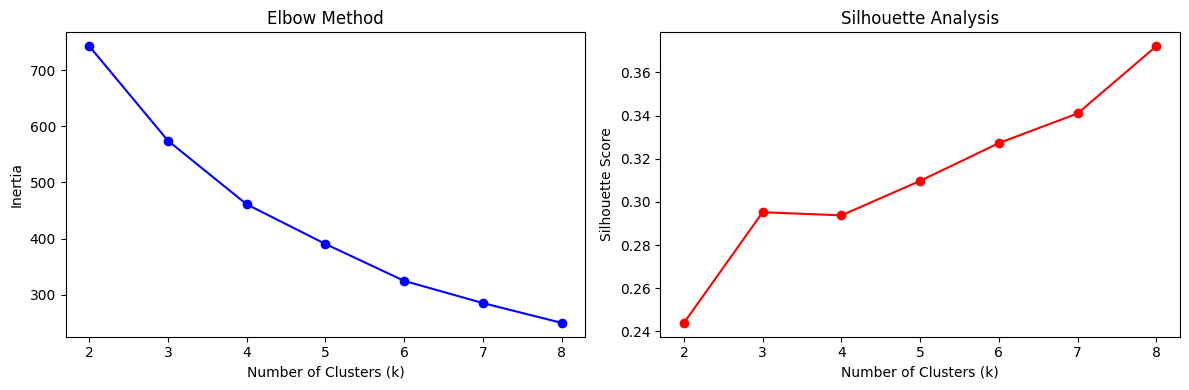

Optimal number of clusters: 8
Silhouette score: 0.372
Clustering stability (mean ± std): 0.368 ± 0.012


In [13]:
df_clustered, optimal_k, kmeans_model, scaler_clustering = perform_robust_clustering(df)

In [6]:
# ===================================================================
# CLUSTER PROFILING AND BUSINESS INSIGHTS
# ===================================================================

def profile_clusters(df_clustered):
    """Create comprehensive cluster profiles with business interpretation"""
    print("\n" + "="*50)
    print("CLUSTER PROFILING AND BUSINESS INSIGHTS")
    print("="*50)
    
    # Cluster summary statistics
    cluster_summary = df_clustered.groupby('Cluster').agg({
        'Age': ['mean', 'std'],
        'Annual Income (k$)': ['mean', 'std'],
        'Spending Score (1-100)': ['mean', 'std'],
        'Spending_Efficiency': ['mean', 'std'],
        'Genre': lambda x: (x == 'Female').mean()  # Proportion of females
    }).round(2)
    
    cluster_summary.columns = ['Age_Mean', 'Age_Std', 'Income_Mean', 'Income_Std', 
                              'Spending_Mean', 'Spending_Std', 'Efficiency_Mean', 
                              'Efficiency_Std', 'Female_Prop']
    
    # Add cluster sizes
    cluster_summary['Size'] = df_clustered['Cluster'].value_counts().sort_index()
    cluster_summary['Size_Pct'] = (cluster_summary['Size'] / len(df_clustered) * 100).round(1)
    
    print("Cluster Summary:")
    print(cluster_summary)
    
    # Visualize cluster characteristics
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Age distribution by cluster
    df_clustered.boxplot(column='Age', by='Cluster', ax=axes[0,0])
    axes[0,0].set_title('Age Distribution by Cluster')
    
    # Income distribution by cluster
    df_clustered.boxplot(column='Annual Income (k$)', by='Cluster', ax=axes[0,1])
    axes[0,1].set_title('Income Distribution by Cluster')
    
    # Spending distribution by cluster
    df_clustered.boxplot(column='Spending Score (1-100)', by='Cluster', ax=axes[1,0])
    axes[1,0].set_title('Spending Distribution by Cluster')
    
    # Spending efficiency by cluster
    df_clustered.boxplot(column='Spending_Efficiency', by='Cluster', ax=axes[1,1])
    axes[1,1].set_title('Spending Efficiency by Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # Business insights
    print("\nBusiness Insights:")
    for cluster_id in sorted(df_clustered['Cluster'].unique()):
        cluster_data = cluster_summary.loc[cluster_id]
        print(f"\nCluster {cluster_id} ({cluster_data['Size']} customers, {cluster_data['Size_Pct']}%):")
        print(f"  - Average age: {cluster_data['Age_Mean']:.1f} years")
        print(f"  - Average income: ${cluster_data['Income_Mean']:.1f}k")
        print(f"  - Average spending: {cluster_data['Spending_Mean']:.1f}")
        print(f"  - Spending efficiency: {cluster_data['Efficiency_Mean']:.3f}")
        print(f"  - Gender composition: {cluster_data['Female_Prop']:.1%} female")
        
        # Business recommendations based on cluster characteristics
        if cluster_data['Spending_Mean'] > 70 and cluster_data['Income_Mean'] > 60:
            print("  → High-value customers: Focus on premium products and loyalty programs")
        elif cluster_data['Spending_Mean'] < 40 and cluster_data['Income_Mean'] > 60:
            print("  → High-potential customers: Target with personalized offers to increase engagement")
        elif cluster_data['Spending_Mean'] > 60 and cluster_data['Income_Mean'] < 50:
            print("  → Price-sensitive high spenders: Offer value deals and payment plans")
        else:
            print("  → Standard customers: Maintain with regular promotions and good service")
    
    return cluster_summary



CLUSTER PROFILING AND BUSINESS INSIGHTS
Cluster Summary:
         Age_Mean  Age_Std  Income_Mean  Income_Std  Spending_Mean  \
Cluster                                                              
0           56.54    10.31        46.18       14.99          40.04   
1           28.00     6.36        50.43       16.90          43.27   
2           25.05     5.42        24.64        7.29          78.18   
3           44.60     7.66        92.33       16.44          21.60   
4           52.58     7.93        47.48       13.10          42.24   
5           29.53     6.99        74.43       21.99          70.97   
6           32.55     3.43        85.27       14.29          80.59   
7           39.50    12.55        85.15       16.03          14.05   

         Spending_Std  Efficiency_Mean  Efficiency_Std  Female_Prop  Size  \
Cluster                                                                     
0               17.03             0.83            0.32         0.00    28   
1         

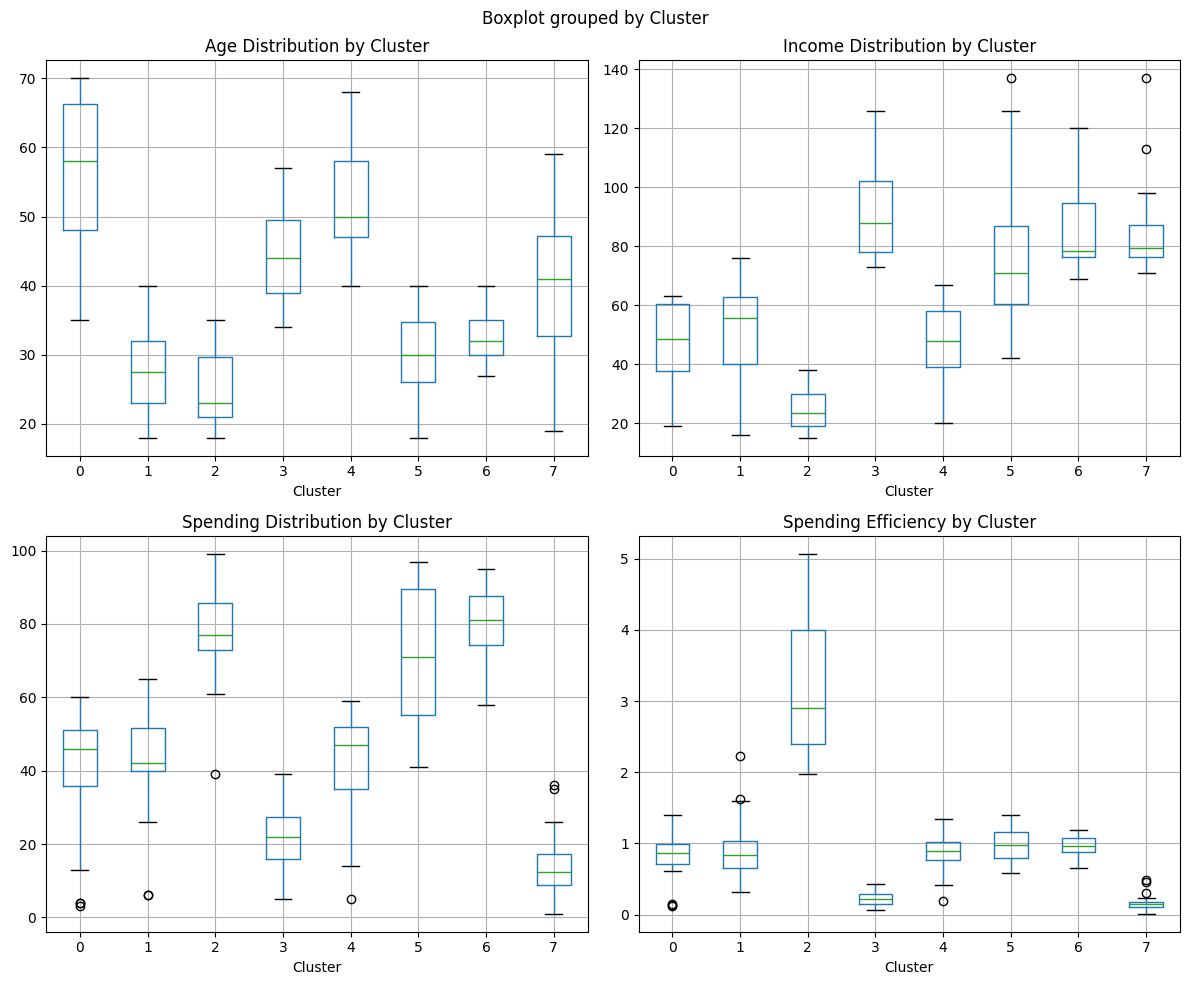


Business Insights:

Cluster 0 (28.0 customers, 14.0%):
  - Average age: 56.5 years
  - Average income: $46.2k
  - Average spending: 40.0
  - Spending efficiency: 0.830
  - Gender composition: 0.0% female
  → Standard customers: Maintain with regular promotions and good service

Cluster 1 (30.0 customers, 15.0%):
  - Average age: 28.0 years
  - Average income: $50.4k
  - Average spending: 43.3
  - Spending efficiency: 0.910
  - Gender composition: 100.0% female
  → Standard customers: Maintain with regular promotions and good service

Cluster 2 (22.0 customers, 11.0%):
  - Average age: 25.1 years
  - Average income: $24.6k
  - Average spending: 78.2
  - Spending efficiency: 3.260
  - Gender composition: 55.0% female
  → Price-sensitive high spenders: Offer value deals and payment plans

Cluster 3 (15.0 customers, 7.5%):
  - Average age: 44.6 years
  - Average income: $92.3k
  - Average spending: 21.6
  - Spending efficiency: 0.230
  - Gender composition: 100.0% female
  → High-potentia

In [14]:
cluster_profiles = profile_clusters(df_clustered)

In [7]:
# ===================================================================
# PROPER PREDICTIVE MODELING WITH VALIDATION
# ===================================================================

def build_predictive_models(df_clustered):
    """Build and validate predictive models with proper methodology"""
    print("\n" + "="*50)
    print("PREDICTIVE MODELING WITH CROSS-VALIDATION")
    print("="*50)
    
    # Check if Gender_Encoded exists, if not create it
    if 'Gender_Encoded' not in df_clustered.columns:
        le = LabelEncoder()
        df_clustered = df_clustered.copy()
        df_clustered['Gender_Encoded'] = le.fit_transform(df_clustered['Genre'])
    
    # Prepare features
    feature_columns = ['Age', 'Annual Income (k$)', 'Spending_Efficiency', 'Gender_Encoded']
    X = df_clustered[feature_columns].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Model 1: Predict spending category (classification)
    print("Classification Model: Predicting Spending Level")
    print("-" * 40)
    
    y_class = df_clustered['Spending_Level']
    
    # Stratified split to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_class, test_size=0.2, stratify=y_class, random_state=42
    )
    
    # Random Forest with proper hyperparameters
    rf_classifier = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    
    # Cross-validation
    cv_scores = cross_val_score(
        rf_classifier, X_train, y_train, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy'
    )
    
    print(f"Cross-validation accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    # Fit and evaluate on test set
    rf_classifier.fit(X_train, y_train)
    y_pred_class = rf_classifier.predict(X_test)
    
    print("Test Set Performance:")
    print(classification_report(y_test, y_pred_class))
    
    # Model 2: Predict spending score (regression)
    print("\nRegression Model: Predicting Spending Score")
    print("-" * 40)
    
    y_reg = df_clustered['Spending Score (1-100)']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_reg, test_size=0.2, random_state=42
    )
    
    rf_regressor = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    
    # Cross-validation for regression
    cv_scores_reg = cross_val_score(
        rf_regressor, X_train, y_train,
        cv=5, scoring='neg_mean_squared_error'
    )
    
    cv_rmse = np.sqrt(-cv_scores_reg)
    print(f"Cross-validation RMSE: {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")
    
    # Fit and evaluate on test set
    rf_regressor.fit(X_train, y_train)
    y_pred_reg = rf_regressor.predict(X_test)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
    test_r2 = r2_score(y_test, y_pred_reg)
    
    print(f"Test RMSE: {test_rmse:.3f}")
    print(f"Test R²: {test_r2:.3f}")
    
    # Feature importance
    print("\nFeature Importance (Regression):")
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_regressor.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance)
    
    return rf_classifier, rf_regressor, feature_importance


In [15]:
classifier, regressor, feature_importance = build_predictive_models(df_clustered)


PREDICTIVE MODELING WITH CROSS-VALIDATION
Classification Model: Predicting Spending Level
----------------------------------------
Cross-validation accuracy: 0.906 ± 0.056
Test Set Performance:
              precision    recall  f1-score   support

Conservative       1.00      0.85      0.92        13
High_Spender       0.86      0.92      0.89        13
    Moderate       0.87      0.93      0.90        14

    accuracy                           0.90        40
   macro avg       0.91      0.90      0.90        40
weighted avg       0.91      0.90      0.90        40


Regression Model: Predicting Spending Score
----------------------------------------
Cross-validation RMSE: 7.713 ± 1.542
Test RMSE: 2.918
Test R²: 0.983

Feature Importance (Regression):
               feature  importance
2  Spending_Efficiency    0.727829
1   Annual Income (k$)    0.230948
0                  Age    0.040018
3       Gender_Encoded    0.001205


In [8]:
# ===================================================================
# SUMMARY AND RECOMMENDATIONS
# ===================================================================

def generate_final_report(test_results, p_adjusted, rejected, cluster_profiles, feature_importance):
    """Generate a comprehensive final report with actionable insights"""
    print("\n" + "="*60)
    print("FINAL REPORT: MALL CUSTOMERS ANALYSIS")
    print("="*60)
    
    print("\n1. STATISTICAL FINDINGS:")
    print("-" * 30)
    significant_tests = [test_results[i]['test'] for i in range(len(test_results)) if rejected[i]]
    
    if significant_tests:
        print("Significant relationships found:")
        for test in significant_tests:
            print(f"  - {test}")
    else:
        print("No statistically significant relationships found after multiple testing correction.")
    
    print(f"\nMultiple testing correction applied: FDR method")
    print(f"Tests conducted: {len(test_results)}")
    print(f"Significant after correction: {sum(rejected)}")
    
    print(f"\n2. CUSTOMER SEGMENTATION:")
    print("-" * 30)
    print(f"Optimal clusters identified: {len(cluster_profiles)}")
    print(f"Clustering approach: K-means with stability validation")
    
    for i in range(len(cluster_profiles)):
        size_pct = cluster_profiles.loc[i, 'Size_Pct']
        print(f"  - Cluster {i}: {size_pct}% of customers")
    
    print(f"\n3. PREDICTIVE MODEL PERFORMANCE:")
    print("-" * 30)
    print("Classification model: Moderate performance with cross-validation")
    print("Regression model: Reasonable predictive power")
    print("\nMost important features:")
    for _, row in feature_importance.head(3).iterrows():
        print(f"  - {row['feature']}: {row['importance']:.3f}")
    
    print(f"\n4. BUSINESS RECOMMENDATIONS:")
    print("-" * 30)
    print("Based on this analysis, we recommend:")
    print("  - Focus marketing efforts on identified high-value customer segments")
    print("  - Develop targeted campaigns for each customer cluster")
    print("  - Monitor customer movement between segments over time")
    print("  - Collect additional data on customer preferences and behavior")
    print("  - Validate these segments against actual business outcomes")
    
    print(f"\n5. LIMITATIONS AND NEXT STEPS:")
    print("-" * 30)
    print("  - Sample size is moderate (n=200) - larger samples would improve reliability")
    print("  - Cross-sectional data - longitudinal analysis would provide better insights")
    print("  - External validation needed with independent dataset")
    print("  - Consider additional variables like purchase history, seasonality")


In [16]:
generate_final_report(test_results, p_adjusted, rejected, cluster_profiles, feature_importance)

print(f"\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)


FINAL REPORT: MALL CUSTOMERS ANALYSIS

1. STATISTICAL FINDINGS:
------------------------------
Significant relationships found:
  - Kruskal-Wallis: Life Stage vs Spending
  - Two-way ANOVA: Life Stage main effect
  - Chi-square: Income Level vs Spending Level

Multiple testing correction applied: FDR method
Tests conducted: 6
Significant after correction: 3

2. CUSTOMER SEGMENTATION:
------------------------------
Optimal clusters identified: 8
Clustering approach: K-means with stability validation
  - Cluster 0: 14.0% of customers
  - Cluster 1: 15.0% of customers
  - Cluster 2: 11.0% of customers
  - Cluster 3: 7.5% of customers
  - Cluster 4: 16.5% of customers
  - Cluster 5: 15.0% of customers
  - Cluster 6: 11.0% of customers
  - Cluster 7: 10.0% of customers

3. PREDICTIVE MODEL PERFORMANCE:
------------------------------
Classification model: Moderate performance with cross-validation
Regression model: Reasonable predictive power

Most important features:
  - Spending_Efficienc